## Importation du fichier audio (wav)

/var/folders/lj/_h0r_q1966b86r6rypmrmfrw0000gn/T/ipykernel_5194/3016233812.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (fs,x) = read("input.wav")


freq echant : 11025
taille : [ 0.05665043  0.00182143 -0.03478009 ...  0.10186798 -0.04766177
  0.11648249]
taille x : 271426
durée : 24.619138321995464 secondes


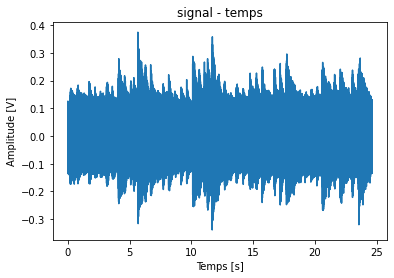

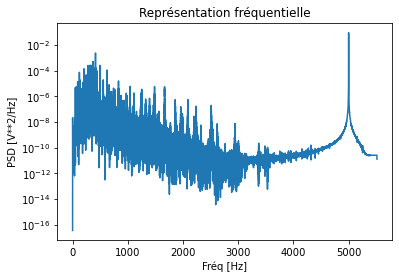

In [1]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import numpy as np
import struct
import os
from scipy import signal
from IPython.display import (Audio, display)
%matplotlib inline

(fs,x) = read("input.wav")
print("freq echant :",fs)
print("taille :",x)
print("taille x :",x.size)
print("durée :",x.size/fs, 'secondes')

#Tracé du signal audio
plt.figure()
t = np.arange(x.size)/fs
plt.plot(t,x)
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude [V]')
plt.title('signal - temps')
plt.show()

#Periodogramme échelle semi-log
fB, Pxx_den = signal.periodogram(x, fs)
plt.semilogy(fB, Pxx_den)
plt.xlabel('Fréq [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Représentation fréquentielle')
plt.show()

#Lecture du signal audio
display(Audio(x, rate=fs, autoplay=True))

---
## Filtrage et sauvegarde

In [2]:
from scipy.io import wavfile
import numpy as np

#Le fichier d'entrée est un fichier wav S/R: 11025Hz Mono 32-bit float
samplerate, data = wavfile.read('input.wav')
output = []
#Coefficients du filtre RIF passe-bas avec une fenêtre de hamming, Fs = 11025, Fc = 3kHz
coeffs = [-0.00045581941038631439,0.0024627943741524234,-0.00016390987220157261,-0.0061204138832738611,
          0.0031028980901724804,0.013427277520441797,-0.012400155886939277,-0.023362277517784979,
          0.034358502598093706,0.03360407700678994,-0.085714933209765462,-0.041310928398418836,
          0.31072804593505071,0.54368968530813855,0.31072804593505071,-0.041310928398418836,
          -0.085714933209765462,0.03360407700678994,0.034358502598093706,-0.023362277517784979,
          -0.012400155886939277,0.013427277520441797,0.0031028980901724804,-0.0061204138832738611,
          -0.00016390987220157261,0.0024627943741524234,-0.00045581941038631439]

coeffs_linearphase = coeffs[0:int((len(coeffs)+1)/2)]
buffer = [0.00]*len(coeffs)

for sample in data:
    buffer.pop(0)
    buffer.append(sample)
    out_sample = 0

    for i in range(len(coeffs_linearphase)):
        coef = coeffs_linearphase[i]
        if i == (len(coeffs_linearphase)-1) :
            out_sample += coef*buffer[(len(coeffs_linearphase)-1)]
        else:
            out_sample += (buffer[i]+buffer[(len(coeffs)-1)-i])*coef

    output.append(np.float32(out_sample))

wavfile.write("output.wav",11025,np.array(output))

/var/folders/lj/_h0r_q1966b86r6rypmrmfrw0000gn/T/ipykernel_5194/343731262.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read('input.wav')


---
## Gabarit du filtre 

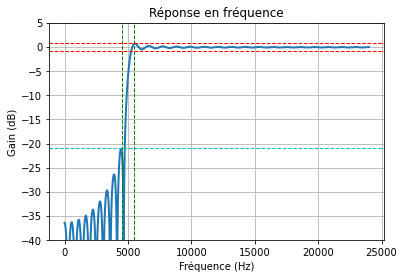

In [3]:
import numpy as np
from scipy.signal import kaiserord, lfilter, firwin, freqz, firwin2
import matplotlib.pyplot as plt
%matplotlib inline

# Fréq de Nyquist.
nyq_rate = 48000 / 2

# Largeur de la bande de transition.
width = 500 / nyq_rate

# Attenuation dans la bande coupée.
ripple_db = 21.0 #12.0

num_of_taps, beta = kaiserord(ripple_db, width)
if num_of_taps % 2 == 0:
    num_of_taps = num_of_taps + 1

# Fréquence de coupure.
cutoff_hz = 5000.0

# Estimation des coefficients du filtre.
taps = firwin(num_of_taps, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)

w, h = freqz(taps, worN=4000)

plt.figure()
plt.plot((w/np.pi)*nyq_rate, 20*np.log10(np.abs(h)), linewidth=2)

plt.axvline(cutoff_hz + width*nyq_rate, linestyle='--', linewidth=1, color='g')
plt.axvline(cutoff_hz - width*nyq_rate, linestyle='--', linewidth=1, color='g')
plt.axhline(-ripple_db, linestyle='--', linewidth=1, color='c')
delta = 10**(-ripple_db/20)
plt.axhline(20*np.log10(1 + delta), linestyle='--', linewidth=1, color='r')
plt.axhline(20*np.log10(1 - delta), linestyle='--', linewidth=1, color='r')

plt.xlabel('Fréquence (Hz)')
plt.ylabel('Gain (dB)')
plt.title('Réponse en fréquence')
plt.ylim(-40, 5)
plt.grid(True)
plt.show()

---
## Synthèse d'un filtre RIF

In [4]:
from pylab import *
import scipy.signal as signal

#Réponse fréquentielle (module et phase)
def mfreqz(b,a=1):
    w,h = signal.freqz(b,a)
    h_dB = 20 * log10 (abs(h))
    figure(figsize=(8,6))
    subplot(211)
    plot(w/max(w),h_dB)
    ylim(-150, 5)
    ylabel('Amplitude [db]')
    xlabel(r'Fréquence normalisée (x $\pi$ rad/échantillon)')
    title(r'Module')
    grid()
    subplot(212)
    h_Phase = unwrap(arctan2(imag(h),real(h)))
    plot(w/max(w),h_Phase)
    ylabel('Phase (rad)')
    xlabel(r'Fréquence normalisée (x $\pi$ rad/échantillon)')
    title(r'Phase')
    grid()
    subplots_adjust(hspace=0.5)

#Réponse indicielle et impulsionnelle
def impz(b,a=1):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = signal.lfilter(b,a,impulse)
    plt.figure(figsize=(8,6))
    subplot(211)
    stem(x, response, use_line_collection = True)
    ylabel('Amplitude')
    xlabel(r'n (échantillons)')
    title(r'Résponse impulsionnelle')
    grid()
    subplot(212)
    step = cumsum(response)
    stem(x, step, use_line_collection = True)
    ylabel('Amplitude')
    xlabel(r'n (échantillons)')
    title(r'Résponse indicielle')
    grid()
    subplots_adjust(hspace=0.5)

## Passe-bas :

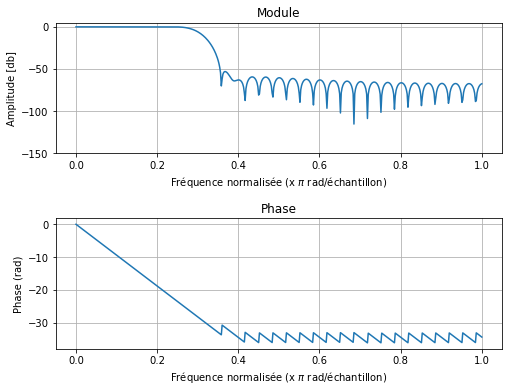

In [5]:
n = 61
a = signal.firwin(n, cutoff = 0.3, window = "hamming")
#Réponse fréquentielle (module et phase)
mfreqz(a)
show()

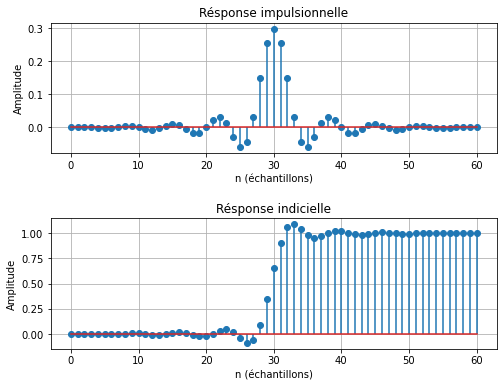

In [6]:
#Réponse impulsionnelle et indicielle
impz(a)
show()

## Passe-haut :

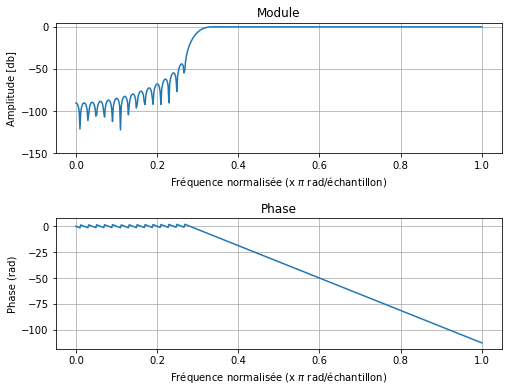

In [7]:
n = 101
a = signal.firwin(n, cutoff = 0.3, window = "hanning", pass_zero=False)
mfreqz(a)
show()

## Passe-bande :

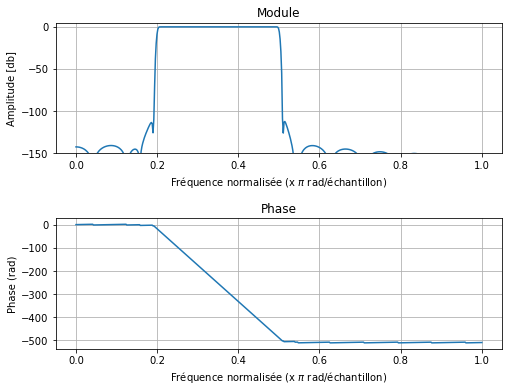

In [8]:
n = 1001
a = signal.firwin(n, cutoff = [0.2, 0.5], window = 'blackmanharris', pass_zero = False)
mfreqz(a)
show()

---
## Filtrage d'un signal

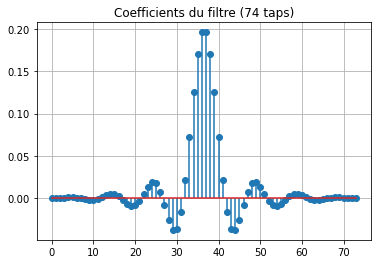

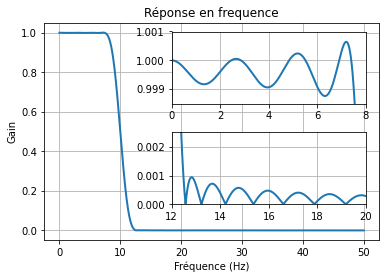

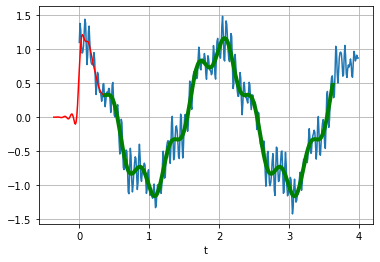

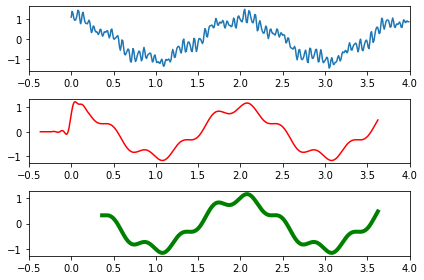

In [13]:
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, stem, xlabel, ylabel, xlim, ylim, title, grid, axes, show
%matplotlib inline

#------------------------------------------------
# Creation du signal de démonstration.
#------------------------------------------------
sample_rate = 100.0
nsamples = 400
t = arange(nsamples) / sample_rate
x = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)


#------------------------------------------------
# Création du filtre RIF et l'appliquer sur x.
#------------------------------------------------

# Fréquence de Nyquist du signal.
nyq_rate = sample_rate / 2.0

# La largeur de la bande de transition,
# est relative à (fonction de) la fréquence de Nyquist.  
# On réalise un le filtre avec une largeur de transition de 5 Hz.  
width = 5.0/nyq_rate

# Atténuation désirée dans la bande coupée, en dB.
ripple_db = 60.0

# Calculer l'ordre et le paramètre de Kaiser pour le filtre RIF. 
N, beta = kaiserord(ripple_db, width)

# La fréquence de coupure du filtre.
cutoff_hz = 10.0

# Utiliser firwin avec une fenêtre de Kaiser pour créer un filtre RIF passe-bas. 
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Utiliser lfilter pour filtrer x avec le filtre RIF. 
filtered_x = lfilter(taps, 1.0, x)

#------------------------------------------------
# Tracé des coefficients du filtre RIF.
#------------------------------------------------
figure(1)
stem(taps, use_line_collection=True)
title('Coefficients du filtre (%d taps)' % N)
grid(True)

#------------------------------------------------
# Tracé de la réponse en fréquence du filtre.
#------------------------------------------------
figure(2)
clf()
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Fréquence (Hz)')
ylabel('Gain')
title('Réponse en frequence')
ylim(-0.05, 1.05)
grid(True)

ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

#------------------------------------------------
# Signaux originaux et filtrés. 
#------------------------------------------------

# Le retard de phase du signal filtré. 
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Signal original.
plot(t, x)
# Tracé le signal filtré, décalé pour compenser le retard de phase. 
plot(t-delay, filtered_x, 'r-')
# Tracé uniquement la "bonne" partie du signal filtré. Les premiers N-1
# échantillons sont "corrompus" par les conditions initiales. 
plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)
xlabel('t')
grid(True)
show()





plt.figure()
plt.subplot(311)
plt.plot(t,x)
plt.xlim([-0.5,4])
plt.subplot(312)
plot(t-delay, filtered_x, 'r-')
plt.xlim([-0.5,4])
plt.subplot(313)
plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)
plt.xlim([-0.5,4])
plt.tight_layout()